In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import scipy
from scipy import integrate
import math

In [2]:
# Collect data from file
def collect_data_float(filename):
    with open(filename) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        # Change strings to floats
        lines = [float(x) for x in lines]
    return lines

In [3]:
# Collecting the data for our initial file
data = collect_data_float('datafile-expresonance.txt')

In [4]:
def hist(data, title):
    
    # Plot histograms
    plt.figure(figsize=(10,10))
    plt.hist(data, bins = 100)
        
    plt.title("Histogram of " + str(title))
    #plt.savefig(str(data_type[Type]) + '_Full_Histogram.pdf')
    plt.show()

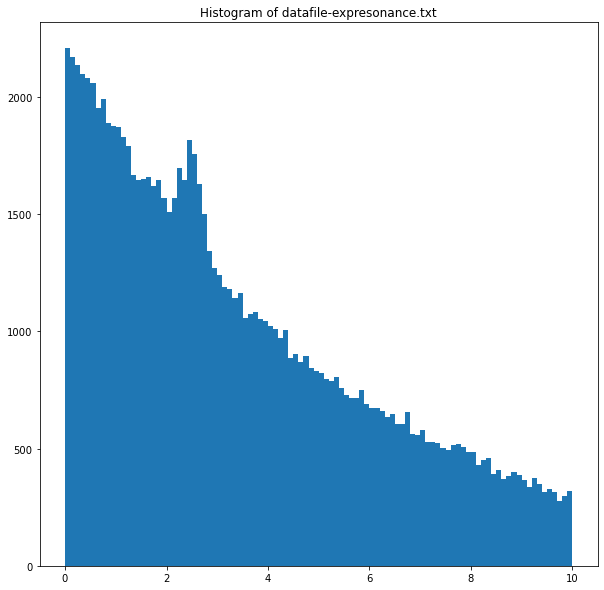

In [167]:
# Plot the data as a histogram
hist(data, "datafile-expresonance.txt")

Visualisation of the data before fitting.

### Checkpoint Part 1

Fitting parameters A, M, and F with Minuit.

I know the course says not to use 'code comments' as documentation of what you're doing, but I feel it will be quite derivative to describe everything in text blocks, then have code comments explain it regardless. I'll do it regardless.

Define Exponential and Gaussian functions

In [6]:
# Define the exponential
def exponential(x, A):
    y = np.exp(-x/A)
    return y

# Define a new gaussian
def gaussian(x, mu):
    # fix sigma for 0.2
    sigma = 0.2
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

Create the combined NLL function for exponential and gaussian.

In [7]:
# Define a combined exponential and gaussian function for NLL
def nll_exp_gauss(M, A, F):
    # F is our fraction for how much of the distribution is gaussian/exponential
    
    # Take data
    x = np.array(data)
        
    # Calculate the y
    y = exponential(x, A)
    # Calculate the normalisation over our exponential over range 0->10
    norm = A * (np.exp(0) - np.exp(-10/A))
    y_norm = y / norm
    
    # Calculating y for the GAUSSIAN
    
    # Calculate the y
    yg = gaussian(x, M)
    # normalise our gaussian, where 0.2 is the sigma
    yg = yg * 1/(np.sqrt(2*np.pi*0.2**2))
    #print(yg)
    
    # Take joint likelihood for the gaussian and exponential
    joint1 = [i * (1-F) for i in yg]
    joint2 = [i * F for i in y_norm]
    joint = np.array([sum(x) for x in zip(joint1, joint2)])
    
    
    # Take log of joint
    y_log = np.log(joint)
    
    # Take negative sum
    nll = -np.sum(y_log)
    
    return nll

Copying in a function provided by DAML course.

In [8]:
# Taken from the notes from two weeks ago to show iminuit results
def showIminuitResult( paramNames, theMinuit ):
    
    #averageList = {}

    fstr = "{0:8.4f}"
    for pn in paramNames :
        val = theMinuit.values[pn]
        err = theMinuit.errors[pn]
        print('\t','{:15s}'.format(pn), ':  \t', fstr.format(val), ' +/- ', fstr.format(err))
    print('\n')

Create minuit object for our NLL function and fit with appropriate limits.

In [9]:
# Create the minuit object to calculate the fit of our function
# over our data
m = Minuit(nll_exp_gauss, M = 2, A = 6, F = 0.5)
# Set errors
m.errors = [0.5,0.5,0.1]
# Define for NLL
m.errordef = 0.5
# Set limits
m.limits = [[1,5], [3,7], [0,1]]

# Fit and show results
result = m.migrad()


Showing results for M, A and F;

In [10]:
showIminuitResult(("M","A","F"), m)

	 M               :  	   2.4985  +/-    0.0146
	 A               :  	   5.0079  +/-    0.0307
	 F               :  	   0.9796  +/-    0.0012




Better shown results for the fitting parameters.
* M - Gaussian Mean
* A - Exponential Decay Constant/Lifetime
* F - Fraction between Gaussian and Exponential (Exponential makes up most of the fraction)

In [11]:
# {:.2} is significant digits (rounded to two)
print("Statistical Errors for data-expresonance.txt")
print("KEY   -   Value Name : Value(Statistical Error)\n")
print("Gaussian Mean (M) : {:.4}({:.2})".format(m.values["M"],m.errors["M"]))
print("Exponential Decay Constant (A) : {:.4}({:.2})".format(m.values["A"],m.errors["A"]))
print("Fraction (F) : {:.4}({:.2})".format(m.values["F"],m.errors["F"]))

Statistical Errors for data-expresonance.txt
KEY   -   Value Name : Value(Statistical Error)

Gaussian Mean (M) : 2.499(0.015)
Exponential Decay Constant (A) : 5.008(0.031)
Fraction (F) : 0.9796(0.0012)


These results match almost exactly with those given in the checkpoint pdf (and are within 1 sigma of the true values), with two significant digits for the statistical errors, and 4 for the true values (seemed to be the best way to relate errors to the data).

### Checkpoint Part 2

Determine a systematic error on the mean of the gaussian by the "shift" method.
This is by applying a different background model (polynomial 2nd order) to determine the fit for our data and comparing to our initial.

So, basically do the same as part 1, but the exponential function is replaced by the polynomial, which we will define now:

In [190]:
# Define 2nd order polynomial
def sec_polynomial(x, a, b, c):
    y = a + b*x + c*(x**2)
    return y

In [217]:
# Define a combined exponential and gaussian function for NLL
def nll_poly_gauss(a, b, c, F, M):
    # F is our fraction for how much of the distribution is gaussian/exponential
    
    # Take data
    x = np.array(data)
        
    # Calculate the y for our polynomial, fix a
    
    y = sec_polynomial(x, a, b, c)
    # In CP says we dont need to normalise, but currently isnt working so will try anyway
    # Found normalisation value based on integral over range 0->10
    norm = 10 *(a + 5*b + (100/3)*c )
    y = y * 1/norm
    
    # limit y so that is cant be zero here. THIS IS REQUIRED OR ELSE CODE WONT RUN
    y = [0 if y[i] < 0 else y[i] for i in range(len(y))]
    
    # Calculating y for the GAUSSIAN
    
    # Calculate the y
    yg = gaussian(x, M)
    # normalise our gaussian, where 0.2 is the sigma
    yg = yg * 1/(np.sqrt(2*np.pi*0.2**2))
    #print(yg)
    
    # Take joint likelihood for the gaussian and exponential
    joint1 = [i * (1-F) for i in yg]
    joint2 = [i * F for i in y]
    joint = np.array([sum(x) for x in zip(joint1, joint2)])
    
    
    # Take log of joint
    y_log = np.log(joint)
    
    # Take negative sum
    nll = -np.sum(y_log)
    
    return nll

Create minuit object, if b/a = -0.016 and c/a = 0.007, but a = 1, then b and c are just those values (for the starting guess). This was revised using the values ascertained below via plotting, still not perfect but better

In [220]:
# Create the minuit object to calculate the fit of our new function
# over our data
n = Minuit(nll_poly_gauss, a = 1, b = -0.1, c= 0.004, F = 0.98, M = 2.5)
# Define for NLL
n.errordef = 0.5
# Set errors
n.errors = [0.5,0.1,0.001,0.1,0.5]
# Set limits
n.limits = [[-5,5],[-0.2,0], [0,1], [0,1], [2,3]]
# Fix a
n.fixed = [True, False, False, False, False]

# Fit and show results
result = n.migrad()


In [221]:
showIminuitResult(("a","M","b","c","F"), n)

	 a               :  	   1.0000  +/-    0.5000
	 M               :  	   2.4943  +/-    0.0156
	 b               :  	  -0.1578  +/-    0.0011
	 c               :  	   0.0073  +/-    0.0001
	 F               :  	   0.9820  +/-    0.0012




In [105]:
result

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -9.265e+04                 │              Nfcn = 101              │
│ EDM = 8.81e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │500.000e-3 │ 0.005e-3  │            │            │  -0.5   │   0.5   │       │
│ 1 │ c    │10.0000e-3 │ 0.0012e-3 │            │            │  -0.01  │  0.01   │       │
│ 2 │ F    │1000.000e-3│ 0.005e-3  │            │            │    0    │    1    │       │
│ 3 │ M    │    2.5    │    0.5    │            │            │    2    │    3    │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │        b        c        F        M │
├───┼─────────────────────────────────────┤
│ b │ 4.25e-17 7.06e-24 -8.6e-25        0 │
│ c │ 7.06e-24  6.1e-17  5.8e-25        0 │
│ F │ -8.6e-25  5.8e-25 6.27e-16        0 │
│ M │        0        0        0        0 │
└───┴─────────────────────────────────────┘

Not getting the right values, unsure how to fix.

Going to plot the values of our different models, using these functions below

In [198]:
# Gauss second order polynomial plotting
def plt_gaus_poly(x, M, b, c, F):

    x = np.array(x)
    # Calculate the y for our polynomial, fix a
    a = 1
    y = sec_polynomial(x, a, b, c)
    norm = 10 *(a + 5*b + (100/3)*c )
    #print(norm)
    y = y * 1/norm

    # Calculating y for the GAUSSIAN
    
    # Calculate the y
    yg = gaussian(x, M)
    # normalise our gaussian, where 0.2 is the sigma
    yg = yg * 1/(np.sqrt(2*np.pi*0.2**2))
    #print(yg)
    
    # Take joint likelihood for the gaussian and exponential
    joint1 = [i * (1-F) for i in yg]
    joint2 = [i * F for i in y]
    joint = np.array([sum(x) for x in zip(joint1, joint2)])
    print("joint: {}".format(joint))
    
    # Take log of joint
    y_log = np.log(joint)
    print("log: {}".format(y_log))
    
    # Take negative sum
    nll = -np.sum(y_log)
    print("nll: {}".format(nll))
    
    # Plot graph
    plt.scatter(x,joint)
    plt.show()
    
    
# Initial model plotting
def plt_gaus_exp(x, M, A, F):
    x = np.array(x)
    
    # Calculate the y
    y = exponential(x, A)
    # Calculate the normalisation over our exponential over range 0->10
    norm = A * (np.exp(0) - np.exp(-10/A))
    y_norm = y / norm
    
    # Calculating y for the GAUSSIAN
    
    # Calculate the y
    yg = gaussian(x, M)
    # normalise our gaussian, where 0.2 is the sigma
    yg = yg * 1/(np.sqrt(2*np.pi*0.2**2))
    #print(yg)
    
    # Take joint likelihood for the gaussian and exponential
    joint1 = [i * (1-F) for i in yg]
    joint2 = [i * F for i in y]
    joint = np.array([sum(x) for x in zip(joint1, joint2)])
    
    print("joint: {}".format(joint))
    
    # Take log of joint
    y_log = np.log(joint)
    print("log: {}".format(y_log))
    
    # Take negative sum
    nll = -np.sum(y_log)
    print("nll: {}".format(nll))
    
    # Plot graph
    plt.scatter(x,joint)
    plt.show()
    
    # Plot graph
    plt.scatter(x,joint)
    plt.show()

Applying these functions with their best values

joint: [0.45275712 0.78138779 0.89923474 ... 0.53165574 0.90753903 0.89133086]
log: [-0.79239946 -0.24668372 -0.10621116 ... -0.63175911 -0.0970187
 -0.11503959]
nll: 35843.70531749925


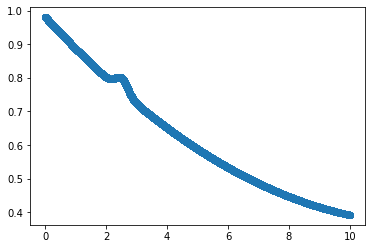

joint: [0.20444004 0.61109868 0.82625309 ... 0.29347519 0.84136014 0.81201938]
log: [-1.58748057 -0.49249682 -0.19085414 ... -1.22596218 -0.17273548
 -0.20823108]
nll: 69831.28880247811


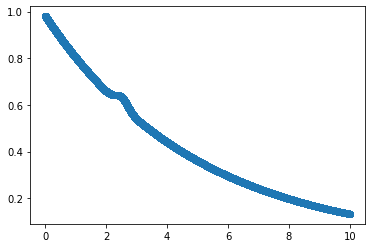

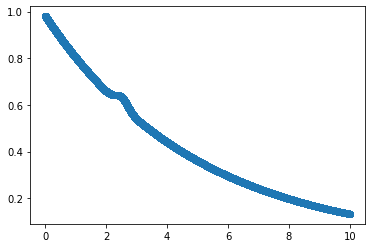

In [188]:
plt_gaus_poly(data, 2.5, -0.1, 0.004, 0.98)
plt_gaus_exp(data, 2.5, 5, 0.98)

Using these values set above (b = -0.1, c = 0.005) I think I can go back and make the model work.

joint: [0.07148797 0.15043697 0.14198443 ... 0.08394564 0.14329564 0.14073645]
log: [-2.63822615 -1.8942111  -1.95203785 ... -2.4775858  -1.94284539
 -1.96086628]
nll: 218368.3686565753


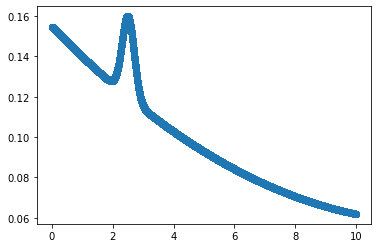

joint: [0.08228854 0.14122623 0.12674095 ... 0.08739871 0.12775579 0.1257782 ]
log: [-2.4975234  -1.9573922  -2.06561003 ... -2.43727476 -2.05763473
 -2.07323524]
nll: 221861.45998512206


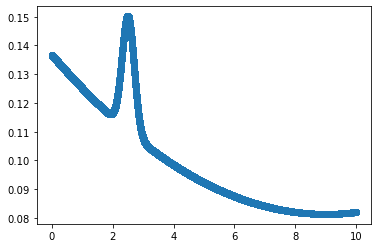

joint: [0.1781383  0.05475476 0.00493249 ... 0.1066004  0.00451463 0.00537725]
log: [-1.72519505 -2.90489093 -5.31191215 ... -2.23866803 -5.40043201
 -5.22557809]
nll: 359833.86599529395


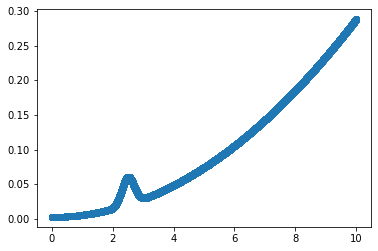

In [199]:
plt_gaus_poly(data, 2.5, -0.1, 0.004, 0.98)
plt_gaus_poly(data, 2.5, -0.09, 0.005, 0.98)
plt_gaus_poly(data, 2.5, 0, 1, 0.98)

### Checkpoint Part 3

Fitting across same data, but now with a straight line background model (which is a bad model that wont fit well.)
Same as before, but now instead of exp or poly, we use y = mx+c